In [2]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

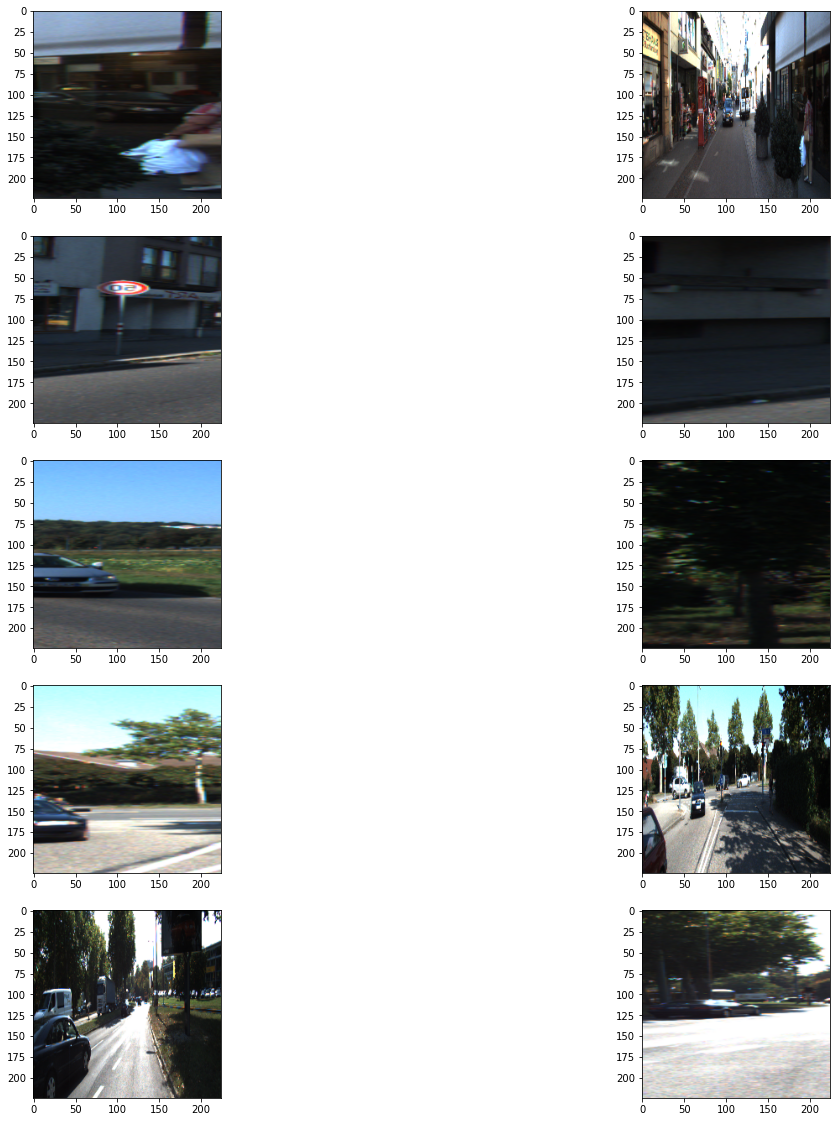

In [9]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(20, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [38]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        
        return data[-30:]
    
    def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
        batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                    "image": _input,
                    "mask": _output,
                   }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs

    def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        
        return self.indexes

In [39]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# U-Net

In [67]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [68]:
model = build_model()
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_500 (Conv2D)             (None, 224, 224, 64) 1792        input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_501 (Conv2D)             (None, 224, 224, 64) 36928       conv2d_500[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_64 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_501[0][0]                 
___________________________________________________________________________________________

In [18]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 27s 674ms/step - loss: 0.7139 - val_loss: 0.5522
Epoch 2/100
11/11 [==============================] - 7s 632ms/step - loss: 0.4512 - val_loss: 0.4374
Epoch 3/100
11/11 [==============================] - 7s 624ms/step - loss: 0.3776 - val_loss: 0.3810
Epoch 4/100
11/11 [==============================] - 7s 622ms/step - loss: 0.3253 - val_loss: 0.3262
Epoch 5/100
11/11 [==============================] - 7s 628ms/step - loss: 0.2735 - val_loss: 0.3682
Epoch 6/100
11/11 [==============================] - 7s 650ms/step - loss: 0.2910 - val_loss: 0.3368
Epoch 7/100
11/11 [==============================] - 7s 632ms/step - loss: 0.2683 - val_loss: 0.3212
Epoch 8/100
11/11 [==============================] - 7s 631ms/step - loss: 0.2188 - val_loss: 0.2702
Epoch 9/100
11/11 [==============================] - 7s 632ms/step - loss: 0.2062 - val_loss: 0.3301
Epoch 10/100
11/11 [==============================] - 7s 633ms/step - loss: 0.2282 - val_l

In [41]:
model = load_model(dir_path + '/seg_model_unet.h5')

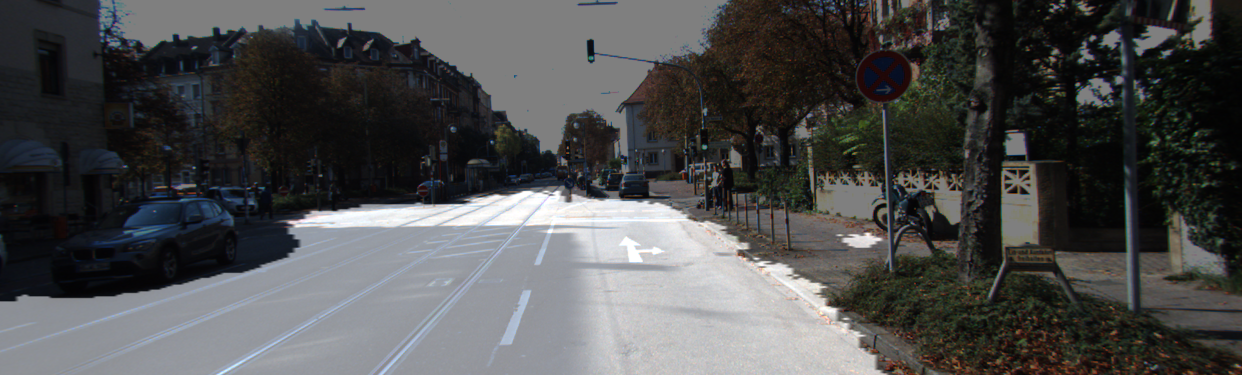

In [42]:
def get_output(model, preproc, image_path, output_path):
    # image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화
    # 이를 output_path에 저장하는 함수.
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output
 

# 시각화한 결과를 눈으로 확인!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

### IoU(Intersection over Union)

In [15]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [14]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [55]:
for i in range(5):
    output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    )

    calculate_iou_score(target, prediction)

IoU : 0.885378
IoU : 0.911429
IoU : 0.745365
IoU : 0.723743
IoU : 0.885003


# U-Net++

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=1,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        
        return data[-30:]
    
    def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
        batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                    "image": _input,
                    "mask": _output,
                   }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs

    def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        
        return self.indexes

In [10]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [94]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_1)
    drop1 = Dropout(0.5)(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_1)
    drop2 = Dropout(0.5)(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    
    up1_2 = Conv2DTranspose(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_1)) 
    merge1_2 = concatenate([up1_2,conv1_1], axis = 3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2)
        
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_1)
    drop3 = Dropout(0.5)(conv3_1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    
    up2_2 = Conv2DTranspose(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_1)) 
    merge2_2 = concatenate([up2_2,conv2_1], axis = 3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_2)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2)
    
    up1_3 = Conv2DTranspose(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2)) 
    merge1_3 = concatenate([up1_3,conv1_1,conv1_2], axis = 3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_3)
    
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_1)
    drop4 = Dropout(0.5)(conv4_1)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    up3_2 = Conv2DTranspose(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4_1)) 
    merge3_2 = concatenate([up3_2, conv3_1], axis = 3)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_2)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_2)
    
    up2_3 = Conv2DTranspose(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_2)) 
    merge2_3 = concatenate([up2_3, conv2_1, conv2_2], axis = 3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_3)
    
    up1_4 = Conv2DTranspose(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_3)) 
    merge1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], axis = 3)
    conv1_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_4)
    conv1_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_4)
        
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5_1)

    up4_2 = Conv2DTranspose(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv5_1)) 
    merge4_2 = concatenate([up4_2, conv4_1], axis = 3)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge4_2)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_2)
    
    up3_3 = Conv2DTranspose(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4_2)) 
    merge3_3 = concatenate([up3_3, conv3_1, conv3_2], axis = 3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_3)

    up2_4 = Conv2DTranspose(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_3)) 
    merge2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], axis = 3)
    conv2_4 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_4)
    conv2_4 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_4)
    
    up1_5 = Conv2DTranspose(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_4)) 
    merge1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], axis = 3)
    conv1_5 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_5)
    conv1_5 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_5)
     
#     conv0 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_5)
#     outputs = Conv2D(1, 1, activation='sigmoid')(conv0)
#     model = Model(inputs=inputs, outputs=outputs)
    
    output1 = Conv2D(1, 1, activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv1_2)
    output2 = Conv2D(1, 1, activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv1_3)
    output3 = Conv2D(1, 1, activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv1_4)
    output4 = Conv2D(1, 1, activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv1_5)
    
    model = Model(inputs=inputs, outputs=output4)
    # model = Model(inputs = inputs, outputs = [output1, output2, output3, output4])
    return model

In [95]:
model = build_model()
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_658 (Conv2D)             (None, 224, 224, 64) 1792        input_22[0][0]                   
__________________________________________________________________________________________________
conv2d_659 (Conv2D)             (None, 224, 224, 64) 36928       conv2d_658[0][0]                 
__________________________________________________________________________________________________
dropout_78 (Dropout)            (None, 224, 224, 64) 0           conv2d_659[0][0]                 
___________________________________________________________________________________________

In [96]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet++_final.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
170/170 [==============================] - 24s 131ms/step - loss: 0.7961 - val_loss: 0.4347
Epoch 2/100
170/170 [==============================] - 22s 129ms/step - loss: 0.2751 - val_loss: 0.3824
Epoch 3/100
170/170 [==============================] - 22s 131ms/step - loss: 0.2550 - val_loss: 0.2823
Epoch 4/100
170/170 [==============================] - 22s 132ms/step - loss: 0.2833 - val_loss: 0.3054
Epoch 5/100
170/170 [==============================] - 23s 134ms/step - loss: 0.2327 - val_loss: 0.3112
Epoch 6/100
170/170 [==============================] - 21s 126ms/step - loss: 0.1877 - val_loss: 0.2789
Epoch 7/100
170/170 [==============================] - 22s 126ms/step - loss: 0.1894 - val_loss: 0.2865
Epoch 8/100
170/170 [==============================] - 23s 135ms/step - loss: 0.1969 - val_loss: 0.2659
Epoch 9/100
170/170 [==============================] - 23s 135ms/step - loss: 0.2021 - val_loss: 0.2676
Epoch 10/100
170/170 [==============================] - 23s 135m

170/170 [==============================] - 23s 135ms/step - loss: 0.0977 - val_loss: 0.1648
Epoch 80/100
170/170 [==============================] - 23s 135ms/step - loss: 0.1026 - val_loss: 0.2635
Epoch 81/100
170/170 [==============================] - 23s 134ms/step - loss: 0.1104 - val_loss: 0.2481
Epoch 82/100
170/170 [==============================] - 23s 134ms/step - loss: 0.1017 - val_loss: 0.2695
Epoch 83/100
170/170 [==============================] - 23s 135ms/step - loss: 0.0774 - val_loss: 0.1348
Epoch 84/100
170/170 [==============================] - 23s 135ms/step - loss: 0.0859 - val_loss: 0.2280
Epoch 85/100
170/170 [==============================] - 23s 135ms/step - loss: 0.0874 - val_loss: 0.2296
Epoch 86/100
170/170 [==============================] - 23s 135ms/step - loss: 0.1090 - val_loss: 0.2164
Epoch 87/100
170/170 [==============================] - 23s 135ms/step - loss: 0.1004 - val_loss: 0.2290
Epoch 88/100
170/170 [==============================] - 23s 134ms/st

In [83]:
model = load_model(dir_path + '/seg_model_unet++.h5')

In [84]:
for i in range(5):
    output, prediction, target = get_output(
         model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    calculate_iou_score(target, prediction)

IoU : 0.927391
IoU : 0.911490
IoU : 0.723596
IoU : 0.746330
IoU : 0.784610


In [89]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
#     output = Image.fromarray(output)
#     background = Image.fromarray(origin_img).convert('RGBA')
#     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
#     output = Image.blend(background, output, alpha=0.5)
#     output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [86]:
model_unet = load_model(dir_path + '/seg_model_unet.h5')
model_nestedunet = load_model(dir_path + '/seg_model_unet++.h5')

In [90]:
unetIoU = []
for i in range(200):
    output, prediction, target = get_output(
         model_unet, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )
    unetIoU.append(calculate_iou_score(target, prediction))

IoU : 0.885378
IoU : 0.911429
IoU : 0.745365
IoU : 0.723743
IoU : 0.885003
IoU : 0.771862
IoU : 0.804965
IoU : 0.891065
IoU : 0.894545
IoU : 0.835136
IoU : 0.851629
IoU : 0.854924
IoU : 0.798769
IoU : 0.876489
IoU : 0.902085
IoU : 0.895420
IoU : 0.896374
IoU : 0.880521
IoU : 0.852204
IoU : 0.903944
IoU : 0.799497
IoU : 0.811674
IoU : 0.926782
IoU : 0.858783
IoU : 0.825365
IoU : 0.875265
IoU : 0.613840
IoU : 0.874230
IoU : 0.897515
IoU : 0.853668
IoU : 0.845912
IoU : 0.854300
IoU : 0.857244
IoU : 0.806428
IoU : 0.885909
IoU : 0.941076
IoU : 0.889100
IoU : 0.902304
IoU : 0.892130
IoU : 0.891266
IoU : 0.892865
IoU : 0.908111
IoU : 0.909129
IoU : 0.895157
IoU : 0.902874
IoU : 0.910549
IoU : 0.892091
IoU : 0.884832
IoU : 0.893791
IoU : 0.836837
IoU : 0.884526
IoU : 0.890690
IoU : 0.903722
IoU : 0.901753
IoU : 0.874711
IoU : 0.819968
IoU : 0.861272
IoU : 0.881777
IoU : 0.870779
IoU : 0.887394
IoU : 0.910058
IoU : 0.927562
IoU : 0.948863
IoU : 0.963409
IoU : 0.878919
IoU : 0.934958
IoU : 0.89

In [91]:
nestIoU = []
for i in range(200):
    output, prediction, target = get_output(
         model_nestedunet, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )
    nestIoU.append(calculate_iou_score(target, prediction))

IoU : 0.927391
IoU : 0.911490
IoU : 0.723596
IoU : 0.746330
IoU : 0.784610
IoU : 0.704888
IoU : 0.808697
IoU : 0.897507
IoU : 0.907011
IoU : 0.862198
IoU : 0.835154
IoU : 0.822109
IoU : 0.730249
IoU : 0.918010
IoU : 0.907722
IoU : 0.894459
IoU : 0.901396
IoU : 0.916791
IoU : 0.895052
IoU : 0.898615
IoU : 0.858498
IoU : 0.922480
IoU : 0.922253
IoU : 0.887640
IoU : 0.906539
IoU : 0.921597
IoU : 0.837969
IoU : 0.917379
IoU : 0.918198
IoU : 0.927509
IoU : 0.880083
IoU : 0.856789
IoU : 0.925229
IoU : 0.910328
IoU : 0.853744
IoU : 0.933454
IoU : 0.881349
IoU : 0.768702
IoU : 0.836942
IoU : 0.883326
IoU : 0.886874
IoU : 0.916139
IoU : 0.905961
IoU : 0.913979
IoU : 0.900805
IoU : 0.912406
IoU : 0.900426
IoU : 0.914498
IoU : 0.906568
IoU : 0.886820
IoU : 0.851258
IoU : 0.895372
IoU : 0.917751
IoU : 0.909483
IoU : 0.931425
IoU : 0.874200
IoU : 0.936927
IoU : 0.926202
IoU : 0.671990
IoU : 0.819640
IoU : 0.918494
IoU : 0.943908
IoU : 0.978490
IoU : 0.981749
IoU : 0.892352
IoU : 0.939754
IoU : 0.95

In [93]:
# 두 모델의 평균 IoU 비교
print("Unet average IoU: ", sum(unetIoU) / len(unetIoU))
print("Unet++ average IoU : ", sum(nestIoU) / len(nestIoU))

Unet average IoU:  0.8541930247390898
Unet++ average IoU :  0.8733583475286535
